In [1]:
import numpy as np
from scipy.stats.distributions import hypergeom
from scipy.stats import multivariate_hypergeom
import matplotlib.pyplot as plt
from random import sample

# The simplest case possible

If we have a mono-colored deck with only basic lands, the probability of casting a X mana value spell is given by the chance of drawing X lands up to turn X, in general the number L of lands drawn up to turn X is modeled as:

$$ L \sim HG(99, l, X+7) $$

In [2]:
mana_curve =  [0, 15, 20, 11, 8, 5, 4]
curve_slots = [i for i in range(len(mana_curve))]
lands = 99 - sum(mana_curve)

probs = [
    hypergeom(99, lands, 7 + i) for i in range(len(mana_curve))
]

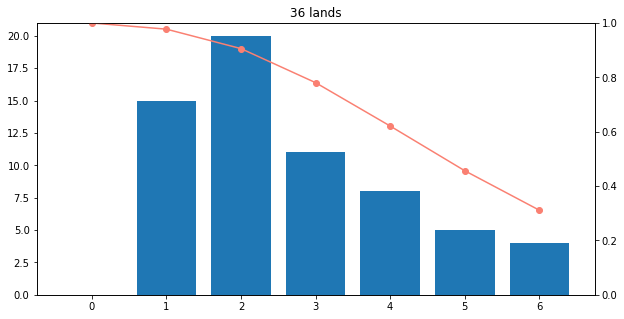

In [3]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set(
    title=f"{lands} lands"
)

ax.bar(curve_slots, mana_curve)

ax_2 = ax.twinx()

# P(L >= x) = 1 - P(L < x)
ax_2.set(
    ylim=(0, 1)
)
ax_2.plot(curve_slots, [1-prob.cdf(slot-1) for prob, slot in zip(probs, curve_slots)], '-o', color='salmon');

# Adding another color

Let's think about two colored decks with only basic lands now, we still need to find the same amount of lands, L

$$ L \sim HG(99, l, X+7) $$

But now, we also need to find the correct colors, number of lands that generate a color $C_x$ is denoted by, for that we use a multivariate hypergeometric distribution with parameters $(\bar l, l_x, l_y)$ where $\bar l$ is the number of non-land cards and $l_x$ is the number of lands that generate the color $x$

Lets consider a Red-Green card which costs {1}{G}{R} in a deck with an even split of 18 Mountains and 18 Forests

In [4]:
L = multivariate_hypergeom(m=[63, 18, 18], n = 10)

## But wait there is more

Now, the probability we can cast the spell is the probability that we draw at least 3 lands, and at least one of each color, since this is really hard to encode, we can cheat and compute it as:

$$P(\text{Can cast}) = \Sigma_{k=3}^{10} \Sigma_{i=1}^{k-1} P(X-k, k-i, i) $$

Note that we choose $k=3$ because we want at least 3 lands, which is the MV of the card, and 10 is the amount of cards we (presumably) draw until turn 3.If we want a more general expression

$$P(\text{Can cast}) = \Sigma_{k=x}^{7+x} \Sigma_{i=1}^{k-1} P(X-k, k-i, i) $$

In [5]:
# All combinations where you have at least 1 of each color and at least 3 lands
combinations = []
for k in range(3, 11):
    combinations.extend([
     (10-k, k-i, i) for i in range(1, k)
    ])
    
p = sum([
    L.pmf(comb) for comb in combinations
])

print(f"Probability of having 1GR after 10 draws (or by turn 3) is {p:.2%}")

Probability of having 1GR after 10 draws (or by turn 3) is 68.65%


Lets check with a simulation, by creating a mock deck and sampling 10 draws for 10000 rounds

In [6]:
# Values for convenience
RED   = 0
GREEN = 1
BLUE  = 2
BLACK = 3
WHITE = 4
COLORS = [RED, GREEN, BLUE, BLACK, WHITE]

In [7]:
def create_deck(lands, size=99):
    total_lands = sum(lands)
    deck = [(0,0,0,0,0)] * (size-total_lands)
    for color, amount in enumerate(lands):
        lands_to_add = [tuple(map(int, f"{1<<4-color:05b}"))] * amount
        deck.extend(lands_to_add)
    return deck

In [8]:
# First we create a deck with 18 Mountains, 18 Forests and 63 spells
deck = create_deck((18, 18), 99)

def simulate(deck, cost, ROUNDS=10000):
    hits = 0
    for i in range(ROUNDS):
        # Draw 10 random cards
        drawn = sample(deck, 7+sum(cost))
        # Count the amount of mana of each color the hand can generate
        colors = [sum(map(lambda x:x[c], drawn)) for c in COLORS]
        
        
        # If we can't even get to the MV, continue
        # This breaks if there are lands that generate more than 1 color
        if sum(colors) < sum(cost):
            continue
        
        can_cast = True
        for color, amount in enumerate(colors):
            # If the amount the hand can generate for a given color
            # is less than the cost requirement, break
            if amount < cost[color]:
                can_cast = False
                break
        if can_cast:
            hits += 1.

    return hits/ROUNDS
           
    
print(f"Simulated probability: {simulate(deck, (1,1,0,0,0,1)):.2%}")

Simulated probability: 68.51%


We can now simulate any deck and any card with only basic lands

In [9]:
# Deck with 18 Mountains, Forest 
deck = create_deck((18,18,), 99)

print(f"Simulated probability: {simulate(deck, (1,0,0,0,0,0)):.2%}") # {R}
print(f"Simulated probability: {simulate(deck, (0,1,0,0,0,0)):.2%}") # {G}
print(f"Simulated probability: {simulate(deck, (1,1,0,0,0,0)):.2%}") # {R}{G}
print(f"Simulated probability: {simulate(deck, (1,1,0,0,0,1)):.2%}") # {1}{R}{G}
print(f"Simulated probability: {simulate(deck, (1,1,1,0,0,0)):.2%}") # {R}{G}{U}

Simulated probability: 81.48%
Simulated probability: 80.85%
Simulated probability: 71.27%
Simulated probability: 68.62%
Simulated probability: 0.00%


The above values should confirm our intuition, 1 mana spells should be easier than 2 color spells and those
should be easier than 3 color spells even if ther MV is the same.

# Well, this is cool and all, but how about dual and tap lands?

Okay, so this all works for decks with only basic lands, but what about dual lands, fetch lands, trilands and others? Well, this gets really messy real quick, but let's give it a shot.

In [10]:
from mtgstats.simulation import *
from tqdm.notebook import tqdm

In [15]:
deck = []
deck.extend([Mountain() for _ in range(17)])
deck.extend([Forest() for _ in range(16)])

deck.extend([Spell() for _ in range(99 - len(deck))])

len(deck)

99

In [16]:
simulator = ManaCurveSimulator(deck)
simulator.run_simulation((1,1,0,0,0,1), 10000)

100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 16816.29it/s]


0.6136

In [19]:
# Cost to tests
costs = [
    (1,0,0,0,0,0), # {R}
    (0,1,0,0,0,0), # {G}
    (1,1,0,0,0,0), # {R}{G}
    (1,1,0,0,0,1), # {1}{R}{G}
    (0,1,0,0,0,2), # {2}{G}
    (0,0,0,0,0,2), # {2}
    (1,1,1,0,0,0), # {R}{G}{U}, should be 0
]

In [20]:
for cost in costs:
    print(f"Probability to cast {cost} on curve is {simulator.run_simulation(cost, 10000):.2%}")

100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 24888.48it/s]


Probability to cast (1, 0, 0, 0, 0, 0) on curve is 78.85%


100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 24889.80it/s]


Probability to cast (0, 1, 0, 0, 0, 0) on curve is 76.29%


100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 19502.67it/s]


Probability to cast (1, 1, 0, 0, 0, 0) on curve is 65.72%


100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 16420.37it/s]


Probability to cast (1, 1, 0, 0, 0, 1) on curve is 63.18%


100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 17285.63it/s]


Probability to cast (0, 1, 0, 0, 0, 2) on curve is 66.45%


100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 20201.72it/s]


Probability to cast (0, 0, 0, 0, 0, 2) on curve is 86.82%


100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 17063.52it/s]

Probability to cast (1, 1, 1, 0, 0, 0) on curve is 0.00%


Okay, our simulations match the predicted values for basics only, that's the best we cando as far as being sure it works for the other cases, now we can use a Genetic Algorithm to optimize our mana base

In [ ]:
# First we define a fitness function
def fitness(deck):
    # Run some checks on the validity of the manabase (to many untapped dual, 5c lands, etc...)
    if not valid_manabase(deck): return 0.
    
    